In [136]:
import os
import wave
import base64
import requests
import json

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import seaborn as sns
sns.set()

In [7]:
os.getcwd()

'/usr/src/app/sample'

# 元データの確認

## 音声データ

In [152]:
class Wavedata:
    """
    フィールド変数
    -----------

    self.binary           : bytes         byte列
    self.base64           : str           bytesをbase64形式に変換した文字列 
    self.array           : numpy_1d_data 音声ファイルから得られたの時系列データ shape(n_length,)
    self.fs               : int           音声ファイルから得られた音声のサンプリング周波数
    self.times            : numpy_1d_data 音声ファイルから得られたの時系列データの時間軸 shape(n_length,)
    """
    
    def __init__(self, filepath: str):
        self.read_wavefile(filepath)

    def read_wavefile(self, filepath: str):
        wf = wave.open(filepath, "rb")
        # サンプリングレート
        fs = wf.getframerate()
        # getnframes -> 全サンプル
        # readframes -> 指定した長さのフレーム
        binary = wf.readframes(wf.getnframes())
        # frombuffer > バイナリ表記をintに変換
        wavedata = np.frombuffer(binary, dtype="int16")
        wf.close()
        
        self.binary = binary
        self.base64 = base64.b64encode(self.binary).decode("UTF-8")
        self.array  = wavedata
        self.fs     = float(fs)
        self.times  = np.arange(0.0, len(self.array)/self.fs, 1/self.fs)
    
    def plot(self, figsize=(20, 6.)):
        df = pd.DataFrame({
            'times[s]': self.times,
            'signal': self.array
        }).set_index('times[s]')
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        df.plot( ax=ax)
        plt.show()

In [153]:
wavedata = Wavedata('./data/sample_01.wav')

In [154]:
wavedata.array

array([-45, -78, -67, ..., -66, -64, -72], dtype=int16)

In [155]:
wavedata.fs

16000.0

In [156]:
wavedata.times

array([0.0000000e+00, 6.2500000e-05, 1.2500000e-04, ..., 5.6798125e+00,
       5.6798750e+00, 5.6799375e+00])

In [157]:
wavedata.binary[0:50]

b'\xd3\xff\xb2\xff\xbd\xff\xba\xff\xb8\xff\xb7\xff\xb8\xff\xba\xff\xbd\xff\xb7\xff\xbd\xff\xb9\xff\xbc\xff\xbb\xff\xb9\xff\xbe\xff\xb8\xff\xc1\xff\xb7\xff\xc3\xff\xbb\xff\xc2\xff\xbd\xff\xbf\xff\xc0\xff'

In [158]:
wavedata.base64[0:50]

'0/+y/73/uv+4/7f/uP+6/73/t/+9/7n/vP+7/7n/vv+4/8H/t/'

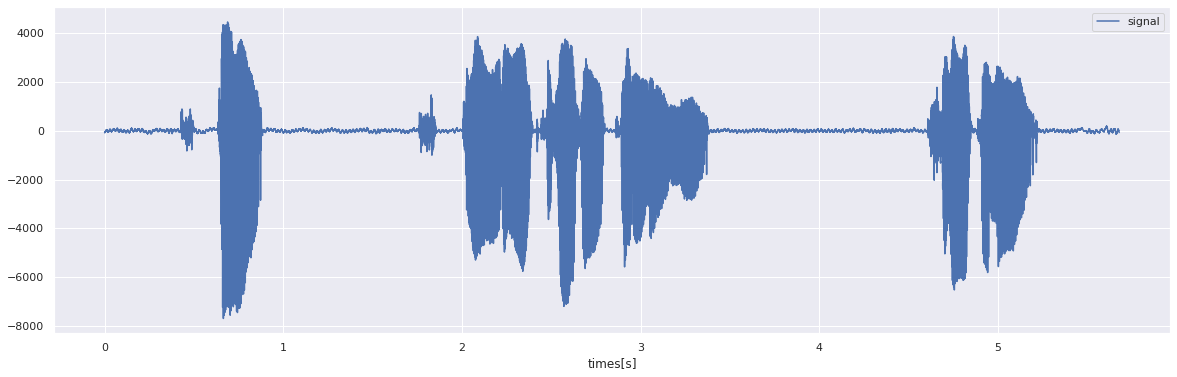

In [159]:
wavedata.plot()

## テキストデータ

In [160]:
f = open('./data/sample_01.txt')
text = f.read().rstrip()  # ファイル終端まで全て読んだデータを返す
f.close()
text

'きっときっとあれおくまでいくんだよねちがうかな'

# APIを叩く

In [161]:
# まずは疎通確認
response = requests.get('http://localhost:8000')

In [162]:
# ステータスコード
response.status_code

200

In [163]:
# レスポンス内容
response.json()

{'接続': '確認！'}

In [198]:
# 音素セグメンテーションapiを叩く
headers: dict = {'content-type': 'application/json'}
request_param: dict = {
    'filename': 'sample_01.wav',
    'wavedata': wavedata.base64,
    'textdata': text
}
response = requests.post('http://localhost:8000', headers=headers, json=request_param)

# レスポンスの確認

In [195]:
response

<Response [200]>

In [200]:
response.json()

[{'phoneme': 'a',
  'wavedata': 'wavedata_base64',
  'filename': 'filename_a_00001111000.wav',
  'arrayIndexFrom': 20,
  'arrayIndexTo': 39,
  'nScore': 0.987},
 {'phoneme': 'a',
  'wavedata': 'wavedata_base64',
  'filename': 'filename_a_00001111000.wav',
  'arrayIndexFrom': 20,
  'arrayIndexTo': 39,
  'nScore': 0.987}]